Assignment 6 vesrion 3 [updating network arch for bottleneck layer]
* Step 1: Removing all Dense layers and updating model for receptive field with 1x1
* Step 2: Removing / updating dropout places and fixing model arch; settingborder_mode='same' for all convolutions
* Step 3: Adding batch norm to address high overfitting
* Step 4: adding lr rate and model saving and reducing traing to 50 epochs

*Results*
* Base Accuracy: 82.73
* Version 2 Step 1 Val Accuracy: 82.74
* Version 2 Step 2 Val acc:81.32 ; Train Acc:.9807 ; High overfitting
* Version 2 Step 3 Val acc:83.89 ; Train Acc:.9926 ; High overfitting
* Version 2 Step 4 Val acc:83.37 ; Train Acc:.9954 ; High overfitting

* Version 3 first run Val acc: 84.2;
* Version 3 Second run Val acc: 85.2;
* Version 3 Second run Val acc: 81.27 (with bottelneck for 2 maxpooling, and no 3rd max pooling)
* Version 3 Second run Val acc: 84.36 (with bottelneck for 2 maxpooling, with 3rd max pooling)

Importing al necessary keras, matplot, numpy libs

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
#preparing check point for saving weights via callback
from google.colab import drive
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Importing, loading data in train and test

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


Viewsing train data for labels.

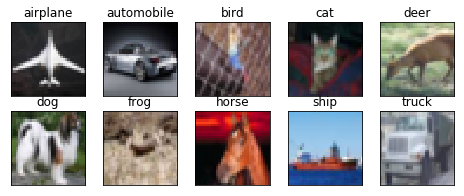

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

Defigning function to plot model training validation accuracy and loss

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Defining function to find and return accracy of trained model in percentage

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Normalizing train and test data 
Converting labels from 1-D to 2-D with leangth of second dimention is num_class

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

Defigning Model and Compiling Model

Applying step 2 changes.

In [30]:
# Define the model
model = Sequential()
model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3))) #RF 3X3
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(48, 3, 3, border_mode='same')) #RF 5X5
model.add(Activation('relu'))
model.add(BatchNormalization())

#creating bottel neck
model.add(Convolution2D(24, 1, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #RF 10X10
#Dropout post maxpooling is not help ful; should move this to conv with 14x14
#model.add(Dropout(0.25))

model.add(Convolution2D(96, 3, 3, border_mode='same')) #RF 12X12
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(96, 3, 3, border_mode='same')) #RF 14X14
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.25))

#creating bottel neck
model.add(Convolution2D(48, 1, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #RF 28X28
#Dropout post maxpooling is not help ful; should move this to conv with 30x30
#model.add(Dropout(0.25))

model.add(Convolution2D(192, 3, 3, border_mode='same')) #RF 30X30
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.25))

model.add(Convolution2D(192, 3, 3, border_mode='same')) #RF 32X32
model.add(Activation('relu'))
model.add(BatchNormalization())

# Creating bottle neck
model.add(Convolution2D(96, 1, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #RF 64X64
model.add(Dropout(0.25))


'''
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
'''

model.add(Convolution2D(10, 1)) 
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(10, 4)) 


model.add(Flatten())
model.add(Activation('softmax'))

#Adding lr rate scheduling and model saving
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
def scheduler(epoch, lr):
  return round(0.01 * 1/(1 + 0.319 * epoch), 10)

filepath="/content/gdrive/My Drive/Weights/Assignment6A_v3_btl-nck_weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callback_list = [LearningRateScheduler(scheduler, verbose=1), checkpoint]

# Compile the model
model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (1, 1), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarnin

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_78 (Activation)   (None, 32, 32, 48)        0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 32, 32, 48)        192       
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 32, 32, 48)        20784     
_________________________________________________________________
activation_79 (Activation)   (None, 32, 32, 48)        0         
_________________________________________________________________
batch_normalization_70 (Batc (None, 32, 32, 48)        192       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 32, 32, 24)        1176      
__________

Training for Epochs = 100 and comparing with Base accuracy is 82.73 
Reducing training epochs to 50

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  del sys.path[0]


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
390/390 [==============================] - 22s 56ms/step - loss: 1.4051 - acc: 0.4876 - val_loss: 2.6288 - val_acc: 0.4204

Epoch 00001: val_acc improved from -inf to 0.42040, saving model to /content/gdrive/My Drive/Weights/Assignment6A_v3_btl-nck_weights-improvement-01-0.4204.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0075815011.
390/390 [==============================] - 16s 40ms/step - loss: 0.9511 - acc: 0.6629 - val_loss: 1.4506 - val_acc: 0.5416

Epoch 00002: val_acc improved from 0.42040 to 0.54160, saving model to /content/gdrive/My Drive/Weights/Assignment6A_v3_btl-nck_weights-improvement-02-0.5416.hdf5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0061050061.
390/390 [==============================] - 15s 39ms/step - loss: 0.7713 - acc: 0.7284 - val_loss: 0.8764 - val_acc: 0.6972

Epoch 00003: val_acc improved from 0.54160 to 0.69720, 

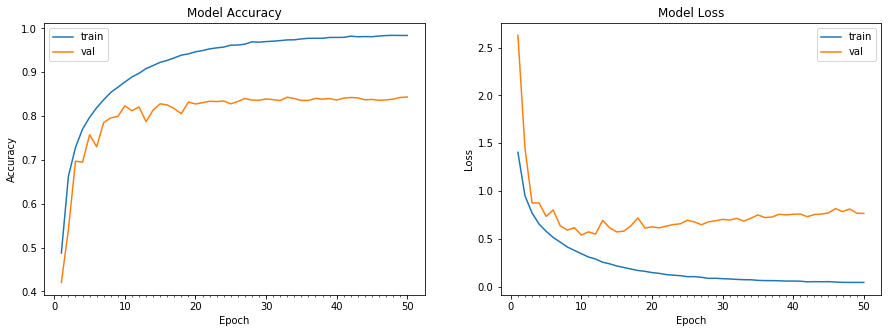

Accuracy on test data is: 84.36


In [32]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1, 
                                 callbacks=callback_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))